<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 13: Boosting

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Part 1: Boosting and Ensembling

We are now going to look at ways in which multiple machine learning can be combined.

In particular, we will look at a way of combining models called *boosting*.
<!-- We are now going to see a different way of combining models called *boosting*. -->

# Review: Components of A Supervised Machine Learning Problem

At a high level, a supervised machine learning problem has the following structure:

$$ \underbrace{\text{Training Dataset}}_\text{Attributes + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

# Review: Overfitting

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset, and doesn't generalize.

# Review: Bagging

The idea of *bagging* is to reduce *overfitting* by averaging many models trained on random subsets of the data.

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = Model().fit(X_i, y_i)
    ensemble.append(model)

# output average prediction at test time:
y_test = ensemble.average_prediction(y_test)
```
The data samples are taken with replacement and known as bootstrap samples.

# Review: Underfitting

Underfitting is another common problem in machine learning.
* The model is too simple to fit the data well (e.g., approximating a high degree polynomial with linear regression).
* As a result, the model is not accurate on training data and is not accurate on new data.

# Boosting

The idea of *boosting* is to reduce *underfitting* by combining models that correct each others' errors.

* As in bagging, we combine many models $g_t$ into one *ensemble* $f$.

* Unlike bagging, the $g_t$ are small and tend to underfit.

* Each $g_t$ fits the points where the previous models made errors.

# Weak Learners

A key ingredient of a boosting algorithm is a *weak learner*.

* Intuitively, this is a model that is slightly better than random.
* Examples of weak learners include: small linear models, small decision trees.

# Structure of a Boosting Algorithm

The idea of *boosting* is to reduce *underfitting* by combining models that correct each others' errors.

1. Fit a weak learner $g_0$ on dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$. Let $f=g$.

2. Compute weights $w^{(i)}$ for each $i$ based on model predictions $f(x^{(i)})$ and targets $y^{(i)}$. Give more weight to points with errors.

3. Fit another weak learner $g_1$ on $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$ with weights $w^{(i)}$.

4. Set $f_1 = g_0 + \alpha_1 g$ for some weight $\alpha_1$. Go to Step 2 and repeat.

In Python-like pseudocode this looks as follows:

```python
weights = np.ones(n_data,)
for i in range(n_models):
    model = SimpleBaseModel().fit(X, y, weights)
    predictions = model.predict(X)
    weights = update_weights(weights, predictions)
    ensemble.add(model)

# output consensus prediction at test time:
y_test = ensemble.consensus_prediction(y_test)
```

# Origins of Boosting

Boosting algorithms were initially developed in the 90s within theoretical machine learning.

* Originally, boosting addressed a theoretical question of whether weak learners with >50% accuracy can be combined to form a strong learner.
* Eventually, this research led to a practical algorithm called *Adaboost*.

Today, there exist many algorithms that are considered types of boosting, even though they were not derived from a theoretical angle.

# Algorithm: Adaboost

* __Type__: Supervised learning (classification).
* __Model family__: Ensembles of weak learners (often decision trees).
* __Objective function__: Exponential loss.
* __Optimizer__: Forward stagewise additive model building.

# Defining Adaboost

One of the first practical boosting algorithms was *Adaboost*.

We start with uniform $w^{(i)} = 1/n$ and $f = 0$. Then for $t=1,2,...,T$:

1. Fit weak learner $g_t$ on $\mathcal{D}$ with weights $w^{(i)}$.

2. Compute misclassification error $e_t = \frac{\sum_{i=1}^n w^{(i)} \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\}}{\sum_{i=1}^n w^{(i)}}$

3. Compute model weight $\alpha_t = \log[(1-e_t)/e_t]$. Set $f \gets f + \alpha_t g_t$.

4. Compute new data weights $w^{(i)} \gets w^{(i)}\exp[\alpha_t \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\} ]$.

# Adaboost: An Example

Let's implement Adaboost on a simple dataset to see what it can do.

Let's start by creating a classification dataset.

In [1]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
import numpy as np
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2., n_samples=200, n_features=2, n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

We can visualize this dataset using `matplotlib`.

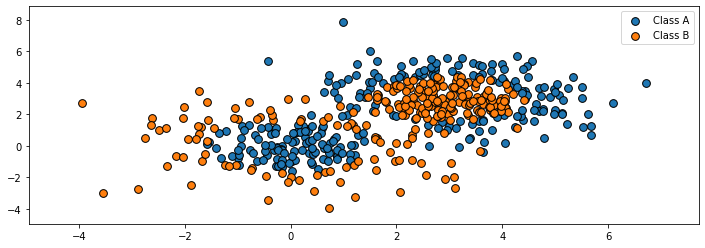

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# Plot the training points
plot_colors, plot_step, class_names = "br", 0.02, "AB"
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], cmap=plt.cm.Paired, s=60, edgecolor='k', label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')

Let's now train Adaboost on this dataset.

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

Visualizing the output of the algorithm, we see that it can learn a highly non-linear decision boundary to separate the two classes.

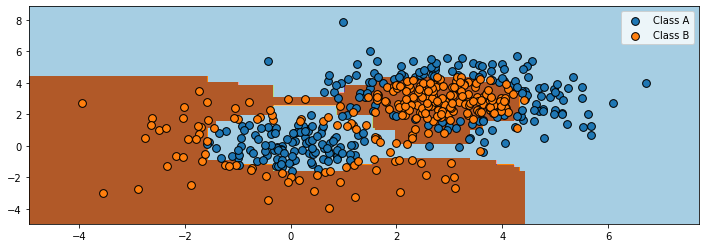

In [14]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

# plot decision boundary
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# plot training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], cmap=plt.cm.Paired, s=60, edgecolor='k', label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')

# Ensembling

Boosting and bagging are special cases of *ensembling*.

The idea of ensembling is to combine many models into one. Bagging and Boosting are ensembling techniques to reduce over- and under-fitting.

* In stacking, we train $m$ independent models $g_j(x)$ (possibly from different model classes) and then train another model $f(x)$ to prodict $y$ from the outputs of the $g_j$.

* The Bayesian approach can also be seen as form of ensembling
$$ P(y\mid x) = \int_\theta P(y\mid x,\theta) P(\theta \mid \mathcal{D}) d\theta $$
where we average models $P(y\mid x,\theta)$ using weights $P(\theta \mid \mathcal{D})$.

# Pros and Cons of Ensembling

Ensembling is a useful tecnique in machine learning.
* It often helps squeeze out additional performance out of ML algorithms.
* Many algorithms (like Adaboost) are forms of ensembling.

Disadvantages include:
* It can be computationally expensive to train and use ensembles.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: Additive Models

Next, we are going to see another perspective on boosting and derive new boosting algorithms.

# The Components of A Supervised Machine Learning Algorithm

We can define the high-level structure of a supervised learning algorithm as consisting of three components:
* A __model class__: the set of possible models we consider.
* An __objective__ function, which defines how good a model is.
* An __optimizer__, which finds the best predictive model in the model class according to the objective function

# Review: Underfitting

Underfitting is another common problem in machine learning.
* The model is too simple to fit the data well (e.g., approximating a high degree polynomial with linear regression).
* As a result, the model is not accurate on training data and is not accurate on new data.

# Review: Boosting

The idea of *boosting* is to reduce *underfitting* by combining models that correct each others' errors.

* As in bagging, we combine many models $g_i$ into one *ensemble* $f$.

* Unlike bagging, the $g_i$ are small and tend to underfit.

* Each $g_i$ fits the points where the previous models made errors.

# Additive Models

Boosting can be seen as a way of fitting an *additive model*:
$$ f(x) = \sum_{t=1}^T \alpha_t g(x; \phi_t). $$

* The main model $f(x)$ consists of $T$ smaller models $g$ with weights $\alpha_t$ and paramaters $\phi_t$.

* The parameters are the $\alpha_t$ plus the parameters $\phi_t$ of each $g$.

This is more general than a linear model, because $g$ can be non-linear in $\phi_t$ (therefore so is $f$).

# Example: Boosting Algorithms

Boosting is one way of training additive models.

1. Fit a weak learner $g_0$ on dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$. Let $f=g$.

2. Compute weights $w^{(i)}$ for each $i$ based on model predictions $f(x^{(i)})$ and targets $y^{(i)}$. Give more weight to points with errors.

3. Fit another weak learner $g_1$ on $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$ with weights $w^{(i)}$.

4. Set $f_1 = g_0 + \alpha_1 g$ for some weight $\alpha_1$. Go to Step 2 and repeat.

# Forward Stagewise Additive Modeling

A general way to fit additive models is the forward stagewise approach.

* Suppose we have a loss $L : \mathcal{Y} \times \mathcal{Y} \to [0, \infty)$.

* Start with $f_0 = \arg \min_\phi \sum_{i=1}^n L(y^{(i)}, g(x^{(i)}; \phi))$.

* At each iteration $t$ we fit the best addition to the current model.
$$ \alpha_t, \phi_t = \arg\min_{\alpha, \phi} \sum_{i=1}^n L(y^{(i)}, f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi))$$

# Practical Considerations

* Popular choices of $g$ include cubic splines, decision trees and kernelized models.
* We may use a fix number of iterations $T$ or early stopping when the error on a hold-out set no longer improves.
* An important design choice is the loss $L$.

# Exponential Loss

Give a binary classification problem with labels $\mathcal{Y} = \{-1, +1\}$, the exponential loss is defined as

$$ L(y, f) = \exp(-y \cdot f). $$

* When $y=1$, $L$ is small when $f \to \infty$.
* When $y=-1$, $L$ is small when $f \to - \infty$.

Let's visualize the exponential loss and compare it to other losses.

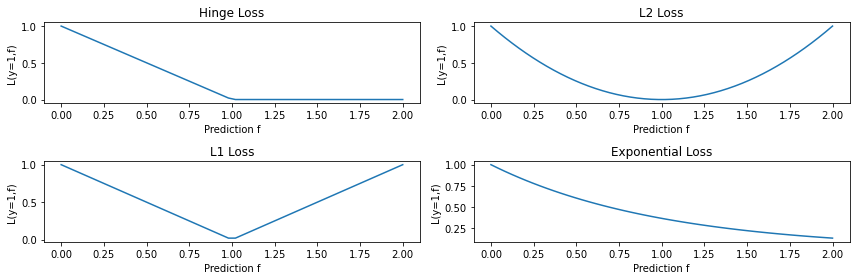

In [23]:
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 4]

# define the losses for a target of y=1
losses = {
    'Hinge' : lambda f: np.maximum(1 - f, 0),
    'L2': lambda f: (1-f)**2,
    'L1': lambda f: np.abs(f-1),
    'Exponential': lambda f: np.exp(-f)
}

# plot them
f = np.linspace(0, 2)
fig, axes = plt.subplots(2,2)
for ax, (name, loss) in zip(axes.flatten(), losses.items()):
    ax.plot(f, loss(f))
    ax.set_title('%s Loss' % name)
    ax.set_xlabel('Prediction f')
    ax.set_ylabel('L(y=1,f)')
plt.tight_layout()

# Special Case: Adaboost

Adaboost is an instance of forward stagewise additive modeling with the expoential loss.

At each step $t$ we minimize
$$L_t = \sum_{i=1}^n e^{-y^{(i)}(f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi))} = \sum_{i=1}^n w^{(i)} \exp\left(-y^{(i)}\alpha g(x^{(i)}; \phi)\right) $$
with $w^{(i)} = \exp(-y^{(i)}f_{t-1}(x^{(i)}))$.

We can derive the Adaboost update rules from this equation.

Suppose that $g(y; \phi) \in \{-1,1\}$. With a bit of algebraic manipulations, we get that:
\begin{align*}
L_t & = e^{\alpha} \sum_{y^{(i)} \neq g(x^{(i)})} w^{(i)} + e^{-\alpha} \sum_{y^{(i)} = g(x^{(i)})} w^{(i)} \\
& = (e^{\alpha} - e^{-\alpha}) \sum_{i=1}^n w^{(i)} \mathbb{I}\{{y^{(i)} \neq g(x^{(i)})}\} + e^{-\alpha} \sum_{i=1}^n w^{(i)}.\\
\end{align*}
where $\mathbb{I}\{\cdot\}$ is the indicator function.

From there, we get that:
\begin{align*}
\phi_t & = \arg\min_{\phi} \sum_{i=1}^n w^{(i)} \mathbb{I}\{{y^{(i)} \neq g(x^{(i)}; \phi)}\} \\
\alpha_t & = \log[(1-e_t)/e_t]
\end{align*}
where $e_t = \frac{\sum_{i=1}^n w^{(i)} \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\}}{\sum_{i=1}^n w^{(i)}\}}$.

These are update rules for Adaboost, and it's not hard to show that the update rule for $w^{(i)}$ is the same as well.

# Squared Loss

Another popular choice of loss is the squared loss.
$$ L(y, f) = (y-f)^2. $$

The resulting algorithm is often called L2Boost. At step $t$ we minimize
$$\sum_{i=1}^n (r^{(i)}_t - g(x^{(i)}; \phi))^2, $$
where $r^{(i)}_t = y^{(i)} - f(x^{(i)})_{t-1}$ is the residual from the model at time $t-1$.

# Logistic Loss

Another common loss is the log-loss. When $\mathcal{Y}=\{-1,1\}$ it is defined as:

$$L(y, f) = \log(1+\exp(-2\cdot y\cdot f)).$$

This looks like the log of the exponential loss; it is less sensitive to outliers since it doesn't penalize large errors as much.

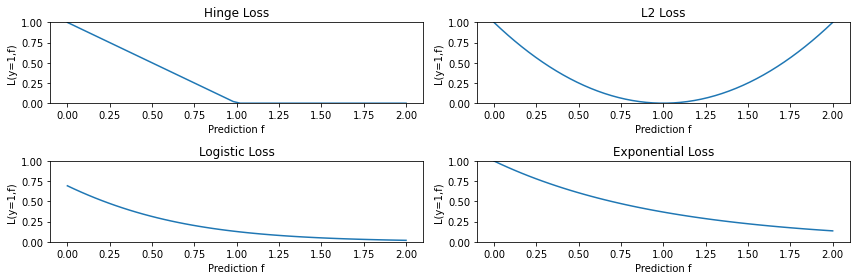

In [25]:
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 4]

# define the losses for a target of y=1
losses = {
    'Hinge' : lambda f: np.maximum(1 - f, 0),
    'L2': lambda f: (1-f)**2,
    'Logistic': lambda f: np.log(1+np.exp(-2*f)),
    'Exponential': lambda f: np.exp(-f)
}

# plot them
f = np.linspace(0, 2)
fig, axes = plt.subplots(2,2)
for ax, (name, loss) in zip(axes.flatten(), losses.items()):
    ax.plot(f, loss(f))
    ax.set_title('%s Loss' % name)
    ax.set_xlabel('Prediction f')
    ax.set_ylabel('L(y=1,f)')
    ax.set_ylim([0,1])
plt.tight_layout()

In the context of boosting, we minimize
$$J(\alpha, \phi) = \sum_{i=1}^n \log\left(1+\exp\left(-2y^{(i)}(f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi)\right)\right).$$

This give a different weight update compared to Adabost. This algorithm is called LogitBoost.

# Pros and Cons of Boosting

The boosting algorithms we have seen so far improve over Adaboost.
* They optimize a wide range of objectives.
* Thus, they are more robust to outliers and extend beyond classification.

Cons:
* Computational time is still an issue.
* Optimizing greedily over each $\phi_t$ can take time.
* Each loss requires specialized derivations.

# Summary

* Additive models have the form
$$ f(x) = \sum_{t=1}^T \alpha_t g(x; \phi_t). $$
* These models can be fit using the forward stagewise additive approach.
* This reproduces Adaboost and can be used to derive new boosting-type algorithms.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Gradient Boosting

We are now going to see another way of deriving boosting algorithms that is inspired by gradient descent.

# Review: Boosting

The idea of *boosting* is to reduce *underfitting* by combining models that correct each others' errors.

* As in bagging, we combine many models $g_i$ into one *ensemble* $f$.

* Unlike bagging, the $g_i$ are small and tend to underfit.

* Each $g_i$ fits the points where the previous models made errors.

# Review: Additive Models

Boosting can be seen as a way of fitting an *additive model*:
$$ f(x) = \sum_{t=1}^T \alpha_t g(x; \phi_t). $$

* The main model $f(x)$ consists of $T$ smaller models $g$ with weights $\alpha_t$ and paramaters $\phi_t$.

* The parameters are the $\alpha_t$ plus the parameters $\phi_t$ of each $g$.

This is not a linear model, because $g$ can be non-linear in $\phi_t$ (therefore so is $f$).

# Review: Forward Stagewise Additive Modeling

A general way to fit additive models is the forward stagewise approach.

* Suppose we have a loss $L : \mathcal{Y} \times \mathcal{Y} \to [0, \infty)$.

* Start with $f_0 = \arg \min_\phi \sum_{i=1}^n L(y^{(i)}, g(x^{(i)}; \phi))$.

* At each iteration $t$ we fit the best addition to the current model.
$$ \alpha_t, \phi_t = \arg\min_{\alpha, \phi} \sum_{i=1}^n L(y^{(i)}, f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi))$$

# Losses for Additive Models

We have seen several losses that can be used with the forward stagewise additive approach.
* The exponential loss $L(y,f) = \exp(-yf)$ gives us Adaboost.
* The log-loss $L(y,f) = \log(1+\exp(-2yf))$ is more robust to outliers.
* The squared loss $L(y,f) = (y-f)^2$ can be used for regression.

# Limitations of Forward Stagewise Additive Modeling

Forward stagewise additive modeling is not without limitations.
* There may exist other losses for which it is complex to derive boosting-type weight update rules.
* At each step, we may need to solve a costly optimization problem over $\phi_t$.
* Optimizing each $\phi_t$ greedily may cause us to overfit.

# Functional Optimization

Functional optimization offers a different angle on boosting algorithms and a recipe for new algorithms.

* Consider optimizing a loss over arbitrary functions $f: \mathcal{X} \to \mathcal{Y}$.

* Functional optimization consists in solving the problem
$$ \min_f \sum_{i=1}^n L(y^{(i)}, f(x^{(i)})). $$
over the space of all possible $f$.

* It's easiest to think about $f$ as an infinite dimensional vector indexed by $x \in \mathcal{X}$.

To simplify our explanations, we will assume that there exists a true deterministic mapping
$$f^* : \mathcal{X} \to \mathcal{Y}$$
between $\mathcal{X}$ and $\mathcal{Y}$, but the algorithm shown here works perfectly without this assumption.

# Functional Gradients

Consider solving the optimization problem using gradient descent:
$$J(f) = \min_f \sum_{i=1}^n L(y^{(i)}, f(x^{(i)})).$$

We may define the functional gradient of this loss at $f_0$ as a function $\nabla J(f_0) : \mathcal{X} \to \mathbb{R}$
$$\nabla J(f_0)(x) = \frac{\partial L(\text{y}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f_0(x), \text{y} = f^*(x)}.$$

Let's make a few observations about the functional gradient
$$\nabla J(f_0)(x) = \frac{\partial L(\text{y}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f_0(x), \text{y} = f^*(x)}.$$

* It's an object indexed by $x \in \mathcal{X}$.

* At each $x \in \mathcal{X}$, $\nabla J(f_0)(x)$ tells us how to modify $f_0(x)$ to make $L(f^*(x), f_0(x))$ smaller.

* This is consistent with the fact that we are optimizing over a "vector" $f$, also indexed by $x \in \mathcal{X}$.

This is best understood via a picture.

<center><img width=100% src="img/functional_gradient.png"></center>

# Functional Gradient Descent

We can optimize our objective using gradient descent in functional space via the usual update rule:
$$f \gets f - \alpha \nabla J(f).$$

As defined, this is not a practical algorithm:
* Minimizing the objective is easy because it's unconstrained.
* The optimal $f$ only fits the training data, and doesn't generalize.
* We only know $J(f)$ at $n$ training points.

# Modeling Functional Gradients

We will address this problem by learning a *model* of gradients.

* In supervised learning, we only have access to $n$ data points that describe the true $\mathcal{X} \to \mathcal{Y}$ mapping.
* We learn a *model* $f_\theta:\mathcal{X} \to \mathcal{Y}$ within a class $\mathcal{M}$ to approximate $f^*$.
* The model extrapolates beyond the training set. Given enough datapoints, $f_\theta$ learns a true mapping.

We will apply the same idea to gradients. 
* We assume a model $g_\theta : \mathcal{X} \to R$ of the functional gradient $\nabla J(f)$ within a class $\mathcal{M}$.
\begin{align*}
g \in \mathcal{M} & & g \approx \nabla_\textbf{f} J(\textbf{f})
\end{align*}
* The model extrapolates beyond the training set. Given enough datapoints, $g_\theta$ learns $\nabla J(f)$.

Functional descent then has the form:
$$\underbrace{f(x)}_\text{new function} \gets \underbrace{f(x) - \alpha g(x)}_\text{old function - gradient step}.$$
If $g$ generalizes, this approximates $f \gets f - \alpha \nabla J(f).$

# Fitting Functional Gradients

What does it mean to approximate a functional gradient $g \approx \nabla_\textbf{f} J(\textbf{f})$ in practice?
We can use standard supervised learning. 

Suppose we have a fixed function $f$ and we want to estimate the functional gradient of $L$
$$\frac{\partial L(\text{y}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f_0(x), \text{y} = f^*(x)}.$$
at any $x \in \mathcal{X}$$

1. We define a loss $L_g$ (e.g., L2 loss) measure how well $g \approx \nabla J(f)$.

2. We compute $\nabla_\textbf{f} J(\textbf{f})$ on the training dataset:
$$\mathcal{D}_g = \left\{ \left(x^{(i)}, \underbrace{\frac{\partial L(y^{(i)}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f(x^{(i)})}}_\text{functional derivative $\nabla_\textbf{f} J(\textbf{f})_i$ at $f(x^{(i)})$} \right), i=1,2,\ldots,n \right\} $$

3. We train a model $g : \mathcal{X} \to \mathbb{R}$ on $\mathcal{D}_g$ to predict functional gradients at any $x$:
$$ g(x) \approx \frac{\partial L(\text{y}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f_0(x), \text{y} = f^*(x)}.$$

# Gradient Boosting

Gradient boosting is a procedure that performs functional gradient descent with approximate gradients.

Start with $f(x) = 0$. Then, at each step $t>1$:

1. Create a training dataset $\mathcal{D}_g$ and fit $g_t(x^{(i)})$ using loss $L_g$:
$$ g_t(x) \approx \frac{\partial L(\text{y}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f_0(x), \text{y} = f^*(x)}.$$

2. Take a step of gradient descent using approximate gradients:
$$f_t(x) = f_{t-1}(x) - \alpha \cdot g_t(x).$$

# Interpreting Gradient Boosting

Notice how after $T$ steps we get an additive model of the form
$$ f(x) = \sum_{t=1}^T \alpha_t g_t(x). $$
This looks like the output of a boosting algorithm!

* This works for any differentiable loss $L$.
* It does not require any mathematical derivations for new $L$.

# Boosting vs. Gradient Boosting

Consider, for example, L2Boost, which optimizes the L2 loss
$$ L(y, f) = \frac{1}{2}(y-f)^2. $$

At step $t$ we minimize
$$\sum_{i=1}^n (r^{(i)}_t - g(x^{(i)}; \phi))^2, $$
where $r^{(i)}_t = y^{(i)} - f(x^{(i)})_{t-1}$ is the residual from the model at time $t-1$.

Observe that the residual
$$r^{(i)}_t = y^{(i)} - f(x^{(i)})_{t-1}$$
is also the gradient of the $L2$ loss with respect to $f$ as $f(x^{(i)})$
$$r^{(i)}_t = \frac{\partial L(y^{(i)}, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f_0(x)}$$

Most boosting algorithms are special cases of gradient boosting in this way.

# Losses for Gradient Boosting

Gradient boosting can optimize a wide range of losses.

1. Regression losses:
    * L2, L1, and Huber (L1/L2 interpolation) losses.
    * Quantile loss: estimates quantiles of distribution of $p(y|x)$.
2. Classification losses:
    * Log-loss, softmax loss, exponential loss, negative binomial likelihood, etc.

# Practical Considerations

When using gradient boosting these additional facts are useful:
* We most often use small decision trees as the learner $g_t$. Thus, input pre-processing is minimal.
* We can regularize by controlling tree size, step size $\alpha$, and using *early stopping*.
* We can scale-up gradient boosting to big data by subsampling data at each iteration (a form of *stochastic* gradient descent).

# Algorithm: Gradient Boosting

* __Type__: Supervised learning (classification and regression).
* __Model family__: Ensembles of weak learners (often decision trees).
* __Objective function__: Any differentiable loss function.
* __Optimizer__: Gradient descent in functional space. Weak learner uses its own optimizer.
* __Probabilistic interpretation__: None in general; certain losses may have one.

# Gradient Boosting: An Example

Let's now try running Gradient Boosted Decision Trees on a small regression dataset.

First we create the dataset.

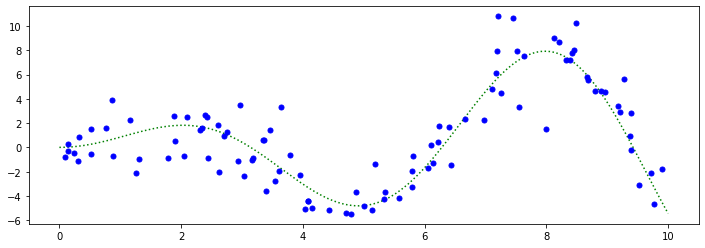

In [21]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Create dataset
f = lambda x: x * np.sin(x)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Visualize it
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')

Next, we train a GBDT regressor.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.95
clf = GradientBoostingRegressor(loss='ls', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.95, min_samples_leaf=9, min_samples_split=9,
                          n_estimators=250)

We may now visualize its predictions

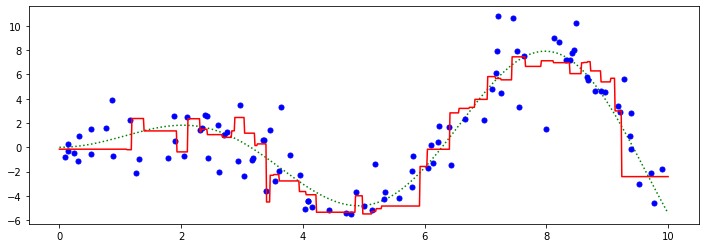

In [22]:
y_pred = clf.predict(xx)
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')

# Pros and Cons of Gradient Boosting

Gradient boosted decision trees (GBTs) are one of the best off-the-shelf ML algorithms that exist, often on par with deep learning.
* Attain state-of-the-art performance. GBTs have won the most Kaggle competitions. 
* Require little data pre-processing and tuning.
* Work with any objective, including probabilistic ones.

Their main limitations are:
* GBTs don't work with unstructured data like images, audio.
* Implementations not as flexible as modern neural net libraries.

# Functional Optimization

Functional optimization offers a different angle on boosting algorithms and a recipe for new algorithms.

* Consider optimizing a loss over arbitrary functions $f: \mathcal{X} \to \mathcal{Y}$.

* Since we only have $n$ datapoints, this reduces to optimizing over vectors $\textbf{f} \in \mathbb{R}^n$

* Thus, functional optimization consists in solving the problem
$$ \min_\textbf{f} \sum_{i=1}^n L(y^{(i)}, \textbf{f}_i). $$

# Functional Gradients

Consider solving the optimization problem using gradient descent:
$$J(\textbf{f}) = \min_\textbf{f} \sum_{i=1}^n L(y^{(i)}, \textbf{f}_i).$$
We may define the functional gradient of this loss as
$$\nabla_\textbf{f} J(\textbf{f}) = \begin{bmatrix}
\frac{\partial L(y^{(1)}, \textbf{f}_1)}{\partial \textbf{f}_1} \\
\frac{\partial L(y^{(2)}, \textbf{f}_2)}{\partial \textbf{f}_2} \\
\vdots \\
\frac{\partial L(y^{(n)}, \textbf{f}_n)}{\partial \textbf{f}_n} \\
\end{bmatrix}.$$

# Functional Gradient Descent

We can optimize our objective using gradient descent in functional space via the usual update rule:
$$\textbf{f} \gets \textbf{f} - \alpha \nabla_\textbf{f} J(\textbf{f}).$$

As defined, this is not a practical algorithm:
* Minimizing the objective is easy because it's unconstrained.
* The optimal $\textbf{f}$ only fits the training data, and doesn't generalize.
* We want a way to optimize $J(\textbf{f})$ at any $n$ training points.

# Modeling Functional Gradients

We will address this problem by learning a *model* of gradients.

<!-- In supervised learning, the mapping $F:\mathcal{X} \to \mathcal{Y}$ could be arbitrary. We assume a *model* $f$ for $F$ within a class $\mathcal{M}$. -->
In supervised learning, we define a *model* $f:\mathcal{X} \to \mathcal{Y}$ for $\textbf{f}$ within a class $\mathcal{M}$.
\begin{align*}
f \in \mathcal{M} & & f \approx \textbf{f}
\end{align*}
The model extrapolates beyond the training set and ensures we generalize.

We will apply the same idea to gradients. We assume a model $g : \mathcal{X} \to R$ of the functional gradient $\nabla_\textbf{f} J(\textbf{f})$ within a class $\mathcal{M}$.
\begin{align*}
g \in \mathcal{M} & & g \approx \nabla_\textbf{f} J(\textbf{f})
\end{align*}
Our model of gradients can generalize beyond the training set.

Functional descent then has the form:
$$\underbrace{f(x)}_\text{new function} \gets \underbrace{f(x) - \alpha g(x)}_\text{old function - gradient step}.$$
If $g$ generalizes, this approximates $\textbf{f} \gets \textbf{f} - \alpha \nabla_\textbf{f} J(\textbf{f})$ at any $n$ points.

# Fitting Functional Gradients

What does it mean to approximate a functional gradient $g \approx \nabla_\textbf{f} J(\textbf{f})$ in practice?
We can use standard supervised learning. 

Suppose we have a fixed function $f$ and we want to estimate the functional gradient of $L$
$$ \frac{\partial L(y, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f(x)}$$
at any value of $f(x)$.

1. We define a loss $L_g$ (e.g., L2 loss) measure how well $g \approx \nabla_\textbf{f} J(\textbf{f})$.

2. We compute $\nabla_\textbf{f} J(\textbf{f})$ on the training dataset:
$$\mathcal{D}_g = \left\{ \left(x^{(i)}, \underbrace{\frac{\partial L(y, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f(x^{(i)})}}_\text{functional derivative $\nabla_\textbf{f} J(\textbf{f})_i$ at $f(x^{(i)})$} \right), i=1,2,\ldots,n \right\} $$

3. We train a model $g : \mathcal{X} \to \mathbb{R}$ on $\mathcal{D}_g$ to predict functional gradients at any $x$:
$$ g(x) \approx \frac{\partial L(y, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f(x)}$$

# Gradient Boosting

Gradient boosting is a procedure that performs functional gradient descent with approximate gradients.

Start with $f(x) = 0$. Then, at each step $t>1$:

1. Create a training dataset $\mathcal{D}_g$ and fit $g_t(x^{(i)})$ using loss $L_g$:
$$ g_t(x) \approx \frac{\partial L(y, \text{f})}{\partial \text{f}} \bigg\rvert_{\text{f} = f(x)}.$$

2. Take a step of gradient descent using approximate gradients:
$$f_t(x) = f_{t-1}(x) - \alpha \cdot g_t(x).$$

# Interpreting Gradient Boosting

Notice how after $T$ steps we get an additive model of the form
$$ f(x) = \sum_{t=1}^T \alpha_t g_t(x). $$
This looks like the output of a boosting algorithm!

* This works for any differentiable loss $L$.
* It does not require any mathematical derivations for new $L$.

# Losses for Gradient Boosting

Gradient boosting can optimize a wide range of losses.

1. Regression losses:
    * L2, L1, and Huber (L1/L2 interpolation) losses.
    * Quantile loss: estimates quantiles of distribution of $p(y|x)$.
2. Classification losses:
    * Log-loss, softmax loss, exponential loss, negative binomial likelihood, etc.

# Practical Considerations

When using gradient boosting these additional facts are useful:
* We most often use small decision trees as the learner $g_t$. Thus, input pre-processing is minimal.
* We can regularize by controlling tree size, step size $\alpha$, and using *early stopping*.
* We can scale-up gradient boosting to big data by subsampling data at each iteration (a form of *stochastic* gradient descent).

# Algorithm: Gradient Boosting

* __Type__: Supervised learning (classification and regression).
* __Model family__: Ensembles of weak learners (often decision trees).
* __Objective function__: Any differentiable loss function.
* __Optimizer__: Gradient descent in functional space. Weak learner uses its own optimizer.
* __Probabilistic interpretation__: None in general; certain losses may have one.

# Gradient Boosting: An Example

Let's now try running Gradient Boosted Decision Trees on a small regression dataset.

First we create the dataset.

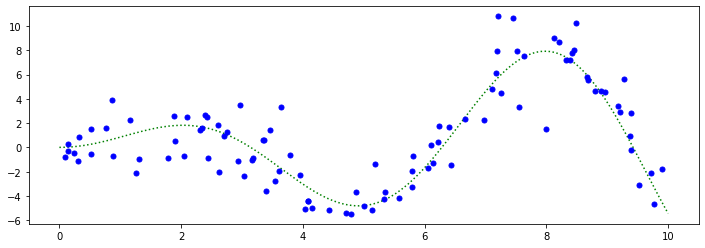

In [21]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Create dataset
f = lambda x: x * np.sin(x)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Visualize it
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')

Next, we train a GBDT regressor.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.95
clf = GradientBoostingRegressor(loss='ls', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.95, min_samples_leaf=9, min_samples_split=9,
                          n_estimators=250)

We may now visualize its predictions

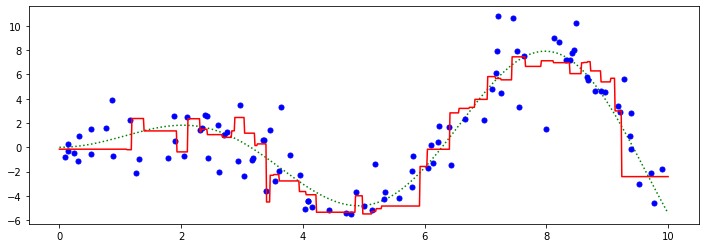

In [22]:
y_pred = clf.predict(xx)
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')

# Pros and Cons of Gradient Boosting

Gradient boosted decision trees (GBTs) are one of the best off-the-shelf ML algorithms that exist, often on par with deep learning.
* Attain state-of-the-art performance. GBTs have won the most Kaggle competitions. 
* Require little data pre-processing and tuning.
* Work with any objective, including probabilistic ones.

Their main limitations are:
* GBTs don't work with unstructured data like images, audio.
* Implementations not as flexible as modern neural net libraries.